In [5]:
import os
import sys
work_dir = '/home/abhijit/nat/Object-Detection'
data_dir = work_dir+'/data/'
util_dir = work_dir+'/data_utilities/'
os.chdir(work_dir)
sys.path.append(util_dir)
sys.path.append(data_dir)

import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
from PIL import Image, ImageDraw 
from tqdm import tqdm
import pickle
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from matplotlib.lines import Line2D
import pandas as pd
from read_write import *
import shutil
from torch.utils.data import random_split, WeightedRandomSampler, DataLoader
import torch.nn as nn
#from utils import *

In [6]:
#Loading our labels
coords, chips, classes = wv.get_labels(data_dir+'xView_train.geojson')

100%|██████████| 601937/601937 [00:03<00:00, 192508.86it/s]


In [7]:
labels = {}
with open(util_dir+'xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

valid_labels = list(labels.keys())

In [8]:
valid_chip_names = load("valid_chip_names.pkl")

id2label = load("class_to_label_map.pkl")

label2id = {v:k for k,v in id2label.items()}

len(id2label)

60

In [7]:
label

NameError: name 'label' is not defined

In [ ]:
id2label = load_object('class_to_label_22classes.pkl')

In [ ]:
def label2idx(labels):
    return {label:label2id[label] for label in labels}

In [89]:
label2idx(['Cargo Truck','Truck w/Box', 'Truck w/Flatbed'])

{'Cargo Truck': '24', 'Truck w/Box': '25', 'Truck w/Flatbed': '28'}

In [35]:
unique, counts = np.unique(classes, return_counts=True)
class_counts = {k:0 for k in list(unique.astype('int64'))}

In [ ]:
transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()])

dataset = ImageFolder(data_dir+'new_t',transform=transform,)

#trainset, valset = random_split(dataset, [189829, 81355])

trainloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

In [ ]:
np.unique(dataset.targets,return_counts=True)

In [ ]:
len(dataset.targets)

In [ ]:
labels1 = [id2label[idx_to_class[i]] for i in range(len(dataset.classes))]

In [ ]:
labels1

In [ ]:
dataset.classes

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=[15,10])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
show(img_grid)

In [ ]:
train_size = 0.7*len(dataset)
val_size = 0.3*len(dataset)
print("full size",len(dataset))
print("train size",train_size)
print("val size",val_size)
189829+81355

In [10]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def plot_classes_preds(images, labels):
    
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 10))
    for idx in np.arange(len(images)):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        ax.set_title(id2label[idx_to_class[labels[idx].item()]])
        matplotlib_imshow(images[idx])
    return fig
#writer = SummaryWriter('runs/Object_detection_experiment_'+str(np.random.randint(0,1000)),flush_secs=1)
#writer.add_figure('Images and labels', plot_classes_preds(images, labels))

In [ ]:
plot_classes_preds(images, labels)

In [11]:
id2label

{'1': 'Plane',
 '2': 'Small Car',
 '3': 'Pickup Utility Truck',
 '4': 'CargoBoxFlatbedTrucks',
 '5': 'Truck Tractor',
 '6': 'Trailer',
 '7': 'Bus',
 '8': 'Passenger Car',
 '9': 'Cargo/Container Car',
 '10': 'Motorboat',
 '11': 'SailTugBoats',
 '12': 'FerryYacht',
 '13': 'Dump Truck',
 '14': 'TractorBulldozer',
 '15': 'Excavator',
 '16': 'Fishing Vessel',
 '17': 'Hut/Tent',
 '18': 'Shed',
 '19': 'Damaged Building',
 '20': 'Vehicle Lot',
 '21': 'Storage Tank',
 '22': 'Shipping container lot'}

In [91]:
valid_chip_names = load("valid_chip_names.pkl")

id2label = load("class_to_label_22classes.pkl")

label2id = {v:k for k,v in id2label.items()}

len(id2label)

22

In [92]:
label2id

{'Plane': '1',
 'Small Car': '2',
 'Pickup Utility Truck': '3',
 'CargoBoxFlatbedTrucks': '4',
 'Truck Tractor': '5',
 'Trailer': '6',
 'Bus': '7',
 'Passenger Car': '8',
 'Cargo/Container Car': '9',
 'Motorboat': '10',
 'SailTugBoats': '11',
 'FerryYacht': '12',
 'Dump Truck': '13',
 'TractorBulldozer': '14',
 'Excavator': '15',
 'Fishing Vessel': '16',
 'Hut/Tent': '17',
 'Shed': '18',
 'Damaged Building': '19',
 'Vehicle Lot': '20',
 'Storage Tank': '21',
 'Shipping container lot': '22'}

In [93]:
total_num_of_images = 0
class_counts = {}
for subdir, dirs, files in os.walk(data_dir+'train_images_top7_weak_split/train'):
    if len(files)>0:
        print(f'{subdir[-2:].split("/")[-1]} {id2label.get(subdir[-2:].split("/")[-1],-1):>25} {len(files):>10}')
        class_counts[id2label.get(subdir[-2:].split("/")[-1],-1)] = len(files)
        total_num_of_images+=len(files)
print(total_num_of_images)

3      Pickup Utility Truck      11747
4     CargoBoxFlatbedTrucks       7230
5             Truck Tractor        599
7                       Bus       4824
18                      Shed        801
13                Dump Truck        945
14          TractorBulldozer        493
26639


In [94]:
class_counts

{'Pickup Utility Truck': 11747,
 'CargoBoxFlatbedTrucks': 7230,
 'Truck Tractor': 599,
 'Bus': 4824,
 'Shed': 801,
 'Dump Truck': 945,
 'TractorBulldozer': 493}

In [ ]:
total_num_of_images

In [18]:
'/3'.split('/')[-1]

'3'

In [ ]:
clas

In [ ]:
import copy
a = copy.deepcopy(class_counts)

In [ ]:
c_count = pd.DataFrame(list(class_counts.values()))
c_count[c_count[0]>700].values[1:]
small_subset_class = {}
a = 0
for label, count in class_counts.items():
    
    if count > 700 and count < 250000:
        small_subset_class[label] = count
        #print(label,count)
        a+=count
print("total",a)
print(small_subset_class)
print("total confirm",sum(list(small_subset_class.values())))
print("len",len(small_subset_class))
#save('class_counts_24classes.pkl',small_subset_class)

In [ ]:
new_classes = load('class_counts_24classes.pkl')
#os.mkdir(data_dir+'train_images_24classes')
# for i in list(new_classes.keys()):
#     os.mkdir(data_dir+'train_images_24classes/'+str(int(label2id[i])))

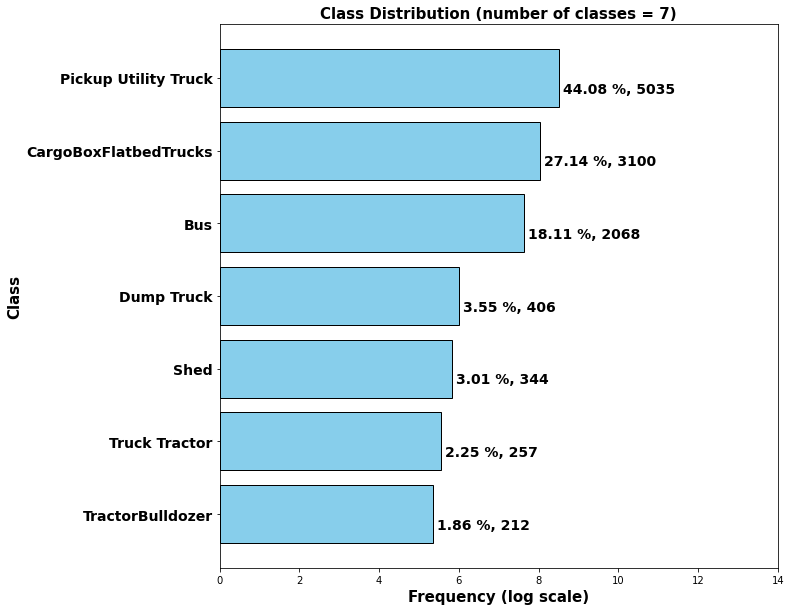

In [27]:
fig, ax = plt.subplots(figsize=[10,10])
class_counts = sorted(class_counts.items(), key=lambda class_counts: class_counts[1])
class_counts = {k: v for k, v in class_counts}
real_count = list(class_counts.values())
total_count = np.sum(real_count)
bars = plt.barh(list(class_counts.keys()), np.log(np.array(list(class_counts.values()))), edgecolor='k',color='skyblue')

for i,bar in enumerate(bars): 
    width = bar.get_width() +0.1
    label_y_pos = bar.get_y() + 0.2 + bar.get_height() // 2
    #ax.text(width,label_y_pos, s=f'{real_count[i]}',fontweight='bold',fontdict={'fontsize':14})
    ax.text(width,label_y_pos, s=f'{np.round(1.0*real_count[i]/total_count,4)*100.0:.2f} %, {real_count[i]}',fontweight='bold',fontdict={'fontsize':14})
    
    if i > 44:
        bar.set_color('#8f9805')
        bar.set_edgecolor('k')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')

custom_lines = [Line2D([0], [0], color='#8f9805', lw=4)]
#plt.legend(custom_lines,['Top 15 most frequent classes'],loc=5,fontsize='large')
plt.title('Class Distribution (number of classes = ' + str(len(real_count))+')',fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':15,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlim(0,14)

plt.show()

In [ ]:
plt.savefig('test_saving1.png')

In [ ]:
fig.savefig('test_saving2.png', bbox_inches='tight')

In [ ]:
save_plot_directory = os.path.join('./runs', os.sep, 'resnet50',os.sep,'blah')

In [ ]:
save_plot_directory

In [ ]:
f = open('old_pixel_areas.pkl','rb')
old_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(old_pixel_areas)),bins=50,color='skyblue',ec="k")

plt.title('Histogram of pixel areas before resampling \n Total number of images = 593,091',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [ ]:
f = open('new_pixel_areas.pkl','rb')
new_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(new_pixel_areas)),bins=20,color='skyblue',ec="k")

plt.title('Histogram of pixel areas after resampling \n Total number of images = 581,470',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [13]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(data_dir+'train_images_top7_weak/', output=data_dir+'train_images_top7_weak/', seed=1337, ratio=(.7, .3), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
#splitfolders.fixed("input_folder", output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values

Copying files: 38061 files [00:03, 11566.20 files/s]


In [ ]:
!pwd

In [ ]:
!pip install split-folders

In [ ]:
data_dir+'train_images_24classess_split'

In [ ]:
splitfolders.ratio()

In [ ]:
import torch.nn as nn

net = nn.Sequential(nn.Linear(20, 6), nn.Linear(6, 3))

In [ ]:
net[0]

In [ ]:
from models.resnet import resnet18

In [ ]:
net = resnet18(5)

In [ ]:
net

In [ ]:
net

In [ ]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:
for name,param in net.named_parameters():
    print(name)

In [ ]:
list(net.children())[-1].named

In [ ]:
net.train()

In [ ]:
input_tensor = torch.Tensor(10, 3, 64, 64)

In [ ]:
net = net.cuda()
output = net(input_tensor)

In [ ]:
a, b = output.max(1)

In [ ]:
b.tolist()

In [ ]:
f = []

In [ ]:
f.extend(b.tolist())

In [ ]:
f

In [ ]:
images, labels = next(iter(trainloader))

In [ ]:
images.shape

In [ ]:
labels

In [ ]:
labels.tolist()

In [ ]:
!nvidia-msi

In [6]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0.0, 0.0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

In [110]:
transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()])
data_dir = './data/'
#os.chdir('../CAP5610/project/')
dataset = ImageFolder(data_dir+'train',transform=transform,)

#trainset, valset = random_split(dataset, [189829, 81355])

trainloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

In [111]:
get_mean_std(trainloader)

(tensor([0.4152, 0.2218, 0.0741]), tensor([0.2658, 0.1433, 0.0785]))

In [ ]:
trainloader_new = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [10]:
a = next(iter(trainloader_new))

In [11]:
img, labels = a

In [108]:
img.shape

torch.Size([2929, 3, 32, 32])

In [12]:
img.mean([0,2,3])

tensor([0.4152, 0.2218, 0.0740])

In [13]:
img.std([0,2,3])

tensor([0.2659, 0.1433, 0.0786])

In [ ]:
x = torch.Tensor(5,3,4,4)

In [14]:
pwd

'/home/abhijit/nat/CAP5610/project'

In [ ]:
torch.mean(x,[0,2,3])

In [ ]:
torch.mean(x[:,2,:,:])

In [ ]:
len(dataset)

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
resnet50 = torchvision.models.resnet50(pretrained=True)

In [ ]:
print(f'{"model":<35} {"requires grad":<10}')
for name, param in resnet50.named_parameters():
    print(f'{name:<35} {str(param.requires_grad):<10}')

In [ ]:
for param in resnet50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)

In [ ]:
print(f'{"model":<35} {"requires grad":<10}')
for name, param in resnet50.named_parameters():
      layer, attr = os.path.splitext(name)
    print(f'{name:<35} {str(param.requires_grad):<10}')

In [ ]:
resnet50.conv1

In [ ]:
for name, param in net.named_parameters():
    layer, attr = os.path.splitext(name)
    print("layer",layer, "attr", attr)

In [ ]:
input_tensor = torch.Tensor(1, 3, 32, 32)

In [ ]:
from utils import *

In [ ]:
net = Net()

In [ ]:
y = net(input_tensor)

In [ ]:
y

In [15]:
acc_1 = pd.read_csv(os.path.join(results_path,'run-efficientnet-b5_Wednesday_28_April_2021_16h_46m_45s-tag-Test_Accuracy.csv'))
acc_2 = pd.read_csv(os.path.join(results_path,'run-efficientnet-b5_Thursday_29_April_2021_01h_35m_56s-tag-Test_Accuracy.csv'))

In [27]:
effnet_b5 = pd.concat([acc_1[:44], acc_2])

In [28]:
effnet_b5

,Wall time,Step,Value
0,1.619643e+09,1,0.271978
1,1.619644e+09,2,0.241758
2,1.619645e+09,3,0.148352
3,1.619645e+09,4,0.541209
4,1.619646e+09,5,0.541209
...,...,...,...
54,1.619705e+09,99,0.848901
55,1.619706e+09,100,0.840659
56,1.619706e+09,101,0.848901
57,1.619707e+09,102,0.848901


In [48]:
results_path = './results'
import os
os.chdir('/home/abhijit/nat/CAP5610/project')
import pandas as pd
import matplotlib.pyplot as plt
def plot_results(filenames, legends, kwargs):
    """
    Args:
        filenames (array of str): names of files containting the data to be plotted
        legends (array of str): legend for each data line
    """
    assert len(filenames) == len(legends), 'length of data files and legends don\'t match'
    plt.figure(figsize=[12,9])
    for filename, legend in zip(filenames, legends):
        data = pd.read_csv(os.path.join(results_path, filename))
        plt.plot(data.Step.values[:100], data.Value.values[:100], label=legend, linewidth=2)
    #plt.plot(effnet_b5.Step.values[:100], effnet_b5.Value.values[:100], label='(EfficientNet-B5) balanced + data augm*', linewidth=2)
    plt.plot(loss_b5.Step.values[:100], loss_b5.Value.values[:100], label='(EfficientNet-B5) balanced + data augm*', linewidth=2)
    plt.title(kwargs['title'])
    plt.xlabel(kwargs['xlabel'])
    plt.ylabel(kwargs['ylabel'])
    plt.legend()
    plt.isinteractive()

In [30]:
loss_fnames = []
acc_fnames = []
for root, sbudir, fnames in os.walk('./results'):
    for f in fnames:
        if 'loss' in f:
            loss_fnames.append(f)
        elif 'Accuracy' in f:
            acc_fnames.append(f)

In [46]:
acc_fnames = ['run-efficientnet-b4_Sunday_18_April_2021_21h_59m_38s-tag-Test_Accuracy.csv',
 'run-resnet18_Thursday_15_April_2021_18h_39m_32s-tag-Test_Accuracy.csv',
 'run-jibanulnet_Monday_26_April_2021_14h_48m_38s-tag-Test_Accuracy.csv',
 'run-resnet18_Saturday_17_April_2021_03h_56m_46s-tag-Test_Accuracy.csv',
 'run-resnet18_Sunday_18_April_2021_13h_30m_18s-tag-Test_Accuracy.csv',
 'run-resnet18_Tuesday_13_April_2021_23h_06m_53s-tag-Test_Accuracy.csv',
 'run-efficientnet-b4_Sunday_25_April_2021_00h_31m_05s-tag-Test_Accuracy.csv',
 'run-efficientnet-b4_Wednesday_21_April_2021_17h_58m_28s-tag-Test_Accuracy.csv']

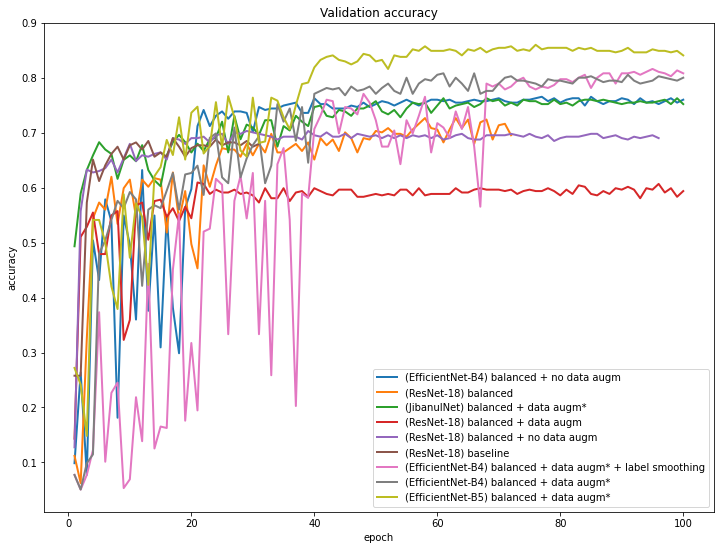

In [47]:
legends = ['(EfficientNet-B4) balanced + no data augm', 
           '(ResNet-18) balanced', 
           '(JibanulNet) balanced + data augm*', 
           '(ResNet-18) balanced + data augm',
           '(ResNet-18) balanced + no data augm',
           '(ResNet-18) baseline',
           '(EfficientNet-B4) balanced + data augm* + label smoothing',
           '(EfficientNet-B4) balanced + data augm*']
kwargs = {'label':legends, 'title': 'Validation accuracy', 'xlabel':'epoch', 'ylabel':'accuracy'}
plot_results(acc_fnames, legends, kwargs)

In [37]:
loss_1 = pd.read_csv(os.path.join(results_path,'run-efficientnet-b5_Wednesday_28_April_2021_16h_46m_45s-tag-Test_Average loss.csv'))
loss_2 = pd.read_csv(os.path.join(results_path,'run-efficientnet-b5_Thursday_29_April_2021_01h_35m_56s-tag-Test_Average loss.csv'))

In [39]:
loss_fnames = ['run-efficientnet-b4_Sunday_18_April_2021_21h_59m_38s-tag-Test_Average loss.csv',
 'run-resnet18_Thursday_15_April_2021_18h_39m_32s-tag-Test_Average loss.csv',
 'run-jibanulnet_Monday_26_April_2021_14h_48m_38s-tag-Test_Average loss.csv',
 'run-efficientnet-b4_Wednesday_21_April_2021_17h_58m_28s-tag-Test_Average loss.csv',
 'run-resnet18_Sunday_18_April_2021_13h_30m_18s-tag-Test_Average loss.csv',
 'run-efficientnet-b4_Sunday_25_April_2021_00h_31m_05s-tag-Test_Average loss.csv',
 'run-resnet18_Saturday_17_April_2021_03h_56m_46s-tag-Test_Average loss.csv',
 'run-resnet18_Tuesday_13_April_2021_23h_06m_53s-tag-Test_Average loss.csv']

In [41]:
loss_b5 = pd.concat([loss_1[:44], loss_2])

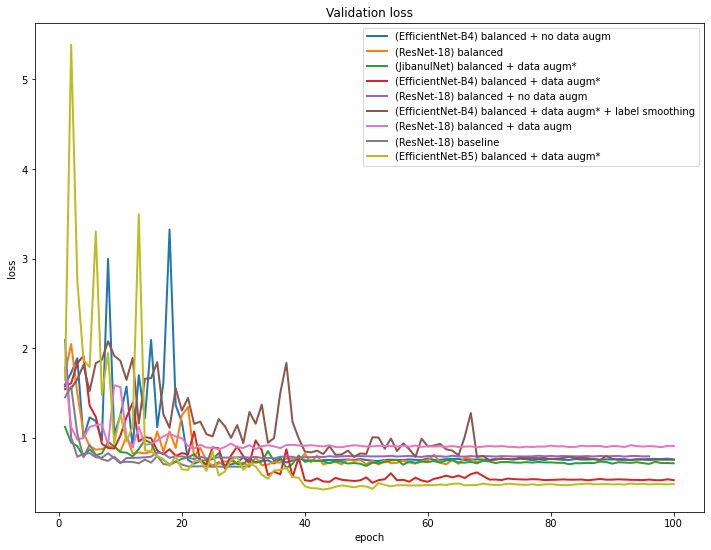

In [49]:
legends = ['(EfficientNet-B4) balanced + no data augm', 
           '(ResNet-18) balanced', 
           '(JibanulNet) balanced + data augm*', 
           '(EfficientNet-B4) balanced + data augm*',
           '(ResNet-18) balanced + no data augm',
           '(EfficientNet-B4) balanced + data augm* + label smoothing',
           '(ResNet-18) balanced + data augm',
           '(ResNet-18) baseline']
kwargs = {'label':legends, 'title': 'Validation loss', 'xlabel':'epoch', 'ylabel':'loss'}
plot_results(loss_fnames, legends, kwargs)

In [77]:
import numpy as np

In [81]:
x = np.random.randint(0,5,(4,5))

In [84]:
np.unique(x, return_counts=True, axis=0)

(array([[0, 0, 3, 3, 4],
        [1, 0, 1, 0, 1],
        [3, 0, 3, 0, 4],
        [3, 2, 3, 4, 2]]), array([1, 1, 1, 1]))

In [87]:
a = 1
b= 2
c =3

In [88]:
[a, b, c]

[1, 2, 3]

In [ ]:
import pandas as pd
test_loss50 = pd.read_csv('run-resnet50_Saturday_13_March_2021_04h_22m_07s-tag-Test_Average loss.csv')
test_acc50 = pd.read_csv('run-resnet50_Saturday_13_March_2021_04h_22m_07s-tag-Test_Accuracy.csv')
test_loss18 = pd.read_csv('run-resnet18_Saturday_13_March_2021_15h_23m_49s-tag-Test_Average loss.csv')
test_acc18 =pd.read_csv('run-resnet18_Saturday_13_March_2021_15h_23m_49s-tag-Test_Accuracy.csv')

In [ ]:
test_loss50_x = test_loss50.Step.values
test_loss50_y = test_loss50.Value.values

test_loss18_x = test_loss18.Step.values
test_loss18_y = test_loss18.Value.values

test_acc50_x = test_acc50.Step.values
test_acc50_y = test_acc50.Value.values

test_acc18_x = test_acc18.Step.values
test_acc18_y = test_acc18.Value.values

In [ ]:
plt.plot(test_loss50_x,test_loss50_y , 'b', label='ResNet50')
plt.plot(test_loss18_x[:49],test_loss18_y[:49] , 'r', label='ResNet18')
plt.title('Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(test_acc50_x, test_acc50_y , 'b', label='ResNet50')
plt.plot(test_acc18_x[:49],test_acc18_y[:49] , 'r', label='ResNet18')
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_acc18

In [ ]:
test_acc50

In [ ]:
import os 
os.chdir('./imbalanced-dataset-sampler')
!python setup.py install
!pip install .

In [141]:
transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()])

dataset = ImageFolder(data_dir+'train_images_22classes_split/train',transform=transform,)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

In [142]:
x = np.unique(dataset.targets, return_counts=True)[1]

In [146]:
max(x)/x

array([0.0043909 , 0.00681392, 0.00426372, 0.00283802, 0.0063253 ,
       0.00329987, 0.00391566, 0.00341365, 0.00329317, 0.00536145,
       0.00480589, 1.        , 0.01491968, 0.00753681, 0.0084739 ,
       0.07862784, 0.04839357, 0.00400937, 0.01900268, 0.03228916,
       0.00747657, 0.00852744])

In [ ]:
x

In [ ]:
one_batch = next(iter(trainloader))

In [ ]:
unique, counts = np.unique(one_batch[1].numpy(), return_counts=True)

In [ ]:
from data_utilities.read_write import *
index_to_class = {index: classs for classs, index in dataset.class_to_idx.items()} 

class_to_label = load("class_to_label_map.pkl")

class_names = [class_to_label[index_to_class[i]] for i in unique]

In [ ]:
class_names

In [ ]:
counts

In [ ]:
total_num_of_images = 0
class_counts = {}
for subdir, dirs, files in os.walk(data_dir+'train_images_24classes_split/train'):
    if len(files)>0:
        print(f'{id2label.get(subdir[-2:],-1):>25} {len(files):>10}')
        class_counts[id2label.get(subdir[-2:],-1)] = len(files)
        total_num_of_images+=len(files)
print(total_num_of_images)

In [ ]:
from torchsampler import ImbalancedDatasetSampler

balanced_train_loader = torch.utils.data.DataLoader(
    dataset, 
    sampler=ImbalancedDatasetSampler(dataset),
    batch_size=25)

In [ ]:
balanced_one_batch = next(iter(balanced_train_loader))

In [ ]:
balanced_unique, balanced_counts = np.unique(balanced_one_batch[1].numpy(), return_counts=True)

In [ ]:
class_names = [class_to_label[index_to_class[i]] for i in balanced_unique]

In [ ]:
balanced_counts

In [ ]:
class_names

In [ ]:
len(class_names)

In [ ]:
for i in range(1,23):
    os.mkdir('./data/train_images_22classes/'+str(i))

In [ ]:
!ls -lh data/train_images_22classes/1

In [125]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(data_dir+'train_images_22classes/', output=data_dir+'train_images_22classes_split', seed=1337, ratio=(.7, .3), group_prefix=None) # default values

Copying files: 272769 files [30:44, 147.85 files/s] 


In [133]:
from utils import load_object, save_object
class_to_label = load_object("class_to_label_map.pkl")

In [130]:
class_to_label

{'11': 'Fixed-wing Aircraft',
 '12': 'Small Aircraft',
 '13': 'Cargo Plane',
 '15': 'Helicopter',
 '17': 'Passenger Vehicle',
 '18': 'Small Car',
 '19': 'Bus',
 '20': 'Pickup Truck',
 '21': 'Utility Truck',
 '23': 'Truck',
 '24': 'Cargo Truck',
 '25': 'Truck w/Box',
 '26': 'Truck Tractor',
 '27': 'Trailer',
 '28': 'Truck w/Flatbed',
 '29': 'Truck w/Liquid',
 '32': 'Crane Truck',
 '33': 'Railway Vehicle',
 '34': 'Passenger Car',
 '35': 'Cargo Car',
 '36': 'Flat Car',
 '37': 'Tank car',
 '38': 'Locomotive',
 '40': 'Maritime Vessel',
 '41': 'Motorboat',
 '42': 'Sailboat',
 '44': 'Tugboat',
 '45': 'Barge',
 '47': 'Fishing Vessel',
 '49': 'Ferry',
 '50': 'Yacht',
 '51': 'Container Ship',
 '52': 'Oil Tanker',
 '53': 'Engineering Vehicle',
 '54': 'Tower crane',
 '55': 'Container Crane',
 '56': 'Reach Stacker',
 '57': 'Straddle Carrier',
 '59': 'Mobile Crane',
 '60': 'Dump Truck',
 '61': 'Haul Truck',
 '62': 'Scraper/Tractor',
 '63': 'Front loader/Bulldozer',
 '64': 'Excavator',
 '65': 'Cement

In [7]:
class_to_label_22classes = {
    
    '1':'Plane',
    '2':'Small Car',
    '3':'PickupUtilityTruck',
    '4':'CargoBoxFlatbedTrucks',
    '5':'Truck Tractor',
    '6':'Trailer',
    '7':'Bus',
    '8':'Passenger Car',
    '9':'Cargo/Container Car',
    '10':'Motorboat',
    '11':'SailTugBoats',
    '12':'FerryYacht',
    '13':'Dump Truck',
    '14':'TractorBulldozer',
    '15':'Excavator',
    '16':'Fishing Vessel',
    '17':'Hut/Tent',
    '18':'Shed',
    '19':'Damaged Building',
    '20':'Vehicle Lot',
    '21':'Storage Tank',
    '22':'Shipping container lot'
}

In [132]:
class_to_label_22classes

{'1': 'Plane',
 '2': 'Small Car',
 '3': 'Pickup Utility Truck',
 '4': 'CargoBoxFlatbedTrucks',
 '5': 'Truck Tractor',
 '6': 'Trailer',
 '7': 'Bus',
 '8': 'Passenger Car',
 '9': 'Cargo/Container Car',
 '10': 'Motorboat',
 '11': 'SailTugBoats',
 '12': 'FerryYacht',
 '13': 'Dump Truck',
 '14': 'TractorBulldozer',
 '15': 'Excavator',
 '16': 'Fishing Vessel',
 '17': 'Hut/Tent',
 '18': 'Shed',
 '19': 'Damaged Building',
 '20': 'Vehicle Lot',
 '21': 'Storage Tank',
 '22': 'Shipping container lot'}

In [136]:
save_object('class_to_label_22classes.pkl', class_to_label_22classes)

In [137]:
a = load_object('class_to_label_22classes.pkl')

In [138]:
a

{'1': 'Plane',
 '2': 'Small Car',
 '3': 'Pickup Utility Truck',
 '4': 'CargoBoxFlatbedTrucks',
 '5': 'Truck Tractor',
 '6': 'Trailer',
 '7': 'Bus',
 '8': 'Passenger Car',
 '9': 'Cargo/Container Car',
 '10': 'Motorboat',
 '11': 'SailTugBoats',
 '12': 'FerryYacht',
 '13': 'Dump Truck',
 '14': 'TractorBulldozer',
 '15': 'Excavator',
 '16': 'Fishing Vessel',
 '17': 'Hut/Tent',
 '18': 'Shed',
 '19': 'Damaged Building',
 '20': 'Vehicle Lot',
 '21': 'Storage Tank',
 '22': 'Shipping container lot'}

In [139]:
pwd

'/home/abhijit/nat/Object-Detection'

In [140]:
ls

 README.md*
 __pycache__/
 checkpoint/
 config.py*
 data/
 data_loader/
 data_utilities/
 imbalanced-dataset-sampler/
 lr_finder.py*
 models/
'models\resnet'/
 obj-detection/
 requirements.txt*
 result.jpg*
 run-resnet18_Saturday_13_March_2021_15h_23m_49s-tag-Test_Accuracy.csv*
'run-resnet18_Saturday_13_March_2021_15h_23m_49s-tag-Test_Average loss.csv'*
 run-resnet50_Saturday_13_March_2021_04h_22m_07s-tag-Test_Accuracy.csv*
'run-resnet50_Saturday_13_March_2021_04h_22m_07s-tag-Test_Average loss.csv'*
 run-resnet50_Saturday_13_March_2021_04h_22m_07s-tag-Train_loss.csv*
 runs/
 train.py*
 utils.py*
 workspace.code-workspace*
 xView_Processing.ipynb*


In [6]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
t = print(classification_report(y_true, y_pred, target_names=target_names))

/home/abhijit/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



In [8]:
t

In [ ]:
sys.stdout = open("test.txt", "w")

print("Hello World")

sys.stdout.close()

In [8]:
with open('out.txt', 'w') as f:
    
    print(classification_report(y_true, y_pred, target_names=target_names),file=f)

In [21]:
numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print('target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=0, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))

target train 0/1: 900/100
batch index 0, 0/1: 51/49
batch index 1, 0/1: 45/55
batch index 2, 0/1: 50/50
batch index 3, 0/1: 50/50
batch index 4, 0/1: 51/49
batch index 5, 0/1: 44/56
batch index 6, 0/1: 49/51
batch index 7, 0/1: 50/50
batch index 8, 0/1: 49/51
batch index 9, 0/1: 42/58


In [2]:
WORKING_DIRECTORY = '/home/abhijit/nat/Object-Detection'
DATA_DIRECTORY = WORKING_DIRECTORY+'/data/'
TOP7_WEAK_TRAIN_DIRECTORY = DATA_DIRECTORY+'train_images_top7_weak_split/train'
TOP7_WEAK_VALIDATION_DIRECTORY = DATA_DIRECTORY+'train_images_top7_weak_split/val'

In [70]:
import torch 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchsampler import ImbalancedDatasetSampler


import PIL

from config import *
from utils import get_stats, get_data_paths

def get_loader(weighted_sampler, use_sampler=False, balanced=False):
    """ Returns a PyTorch data loader object
    

    """
    loader = {}
    datasets = {}

    mean, std = [0.2706, 0.2209, 0.1884], [0.1599, 0.1395, 0.1295]
    train_path, val_path = TOP7_WEAK_TRAIN_DIRECTORY, TOP7_WEAK_VALIDATION_DIRECTORY

    transformations = {'training_transform':transforms.Compose([
                                        transforms.Resize((32, 32)),
                                        transforms.ColorJitter(hue=.05, saturation=.05, brightness=0.09),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)]),

                        'validation_transform':transforms.Compose([
                                        transforms.Resize((32, 32)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])
                        }

    train_set = ImageFolder(root=train_path, transform=transformations['training_transform'], )
    validation_set = ImageFolder(root=val_path, transform=transformations['validation_transform'])

    if balanced:
        print("Balanced training")
        loader['training'] = DataLoader(train_set, sampler=ImbalancedDatasetSampler(train_set), batch_size=128, num_workers=0)
    elif use_sampler:
        print("Using custom sampler")
        loader['training'] = DataLoader(train_set, sampler=weighted_sampler, batch_size=128, num_workers=0)
    else:
        print("Imbalanced training")
        loader['training'] = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
    
    loader['validation'] = DataLoader(validation_set, batch_size=128, num_workers=0)

    datasets['training'] = train_set
    datasets['validation'] = validation_set

    return datasets, loader


In [9]:
datasets, loader = get_loader()

Balanced training


In [10]:
import numpy as np
for images, labels in loader['training']:
    print(np.unique(labels.numpy(), return_counts=True)[1])

[17 19 16 29 15 15 17]
[13 16 20 15 22 27 15]
[17 20 19 14 23 11 24]
[19 16 22 31 12 14 14]
[20 24 17 18 14 20 15]
[21 18 13 27 13 20 16]
[15 13 24 29 15 17 15]
[21 19 26 16 20 13 13]
[13 15 12 23 30 16 19]
[17 22 16 19 16 17 21]
[20 23 18 17 19 13 18]
[26 14 14 15 20 20 19]
[24 18 11 21 17 23 14]
[21 20 19 21 15 13 19]
[13 15 19 19 24 18 20]
[18 23 13 23 13 17 21]
[26 20 20 13 17 19 13]
[11 18 17 12 16 34 20]
[12 18 20 21 25 19 13]
[13 24 19 19 18 14 21]
[24 17 14 12 19 19 23]
[17 17 18 18 23 19 16]
[21 19 19 14 17 21 17]
[18 17 21 13 16 17 26]
[24 13 21 17 17 16 20]
[14 12 17 29 17 17 22]
[18 26 19 16 11 20 18]
[15 15 24 26 14 13 21]
[18 21 19 25 13 19 13]
[14 13 25 27 22 15 12]
[22 18 14 25 17 17 15]
[17 21 18 24 16 18 14]
[16 21 17 17 21 16 20]
[25 18 19 17 20 18 11]
[18 22 24 20 17 11 16]
[16 14 14 20 22 18 24]
[13 14 14 24 24 19 20]
[15 19 22 21 15 18 18]
[13 23 16 21 17 23 15]
[23 14 23 15 16 20 17]
[12 23 22 15 17 22 17]
[14 17 17 19 22 18 21]
[12 23 18 22 23 16 14]
[18 21 13 1

In [54]:
class_counts = np.unique(loader['training'].dataset.targets, return_counts=True)[1]

In [55]:
class_weights = 1./class_counts

In [56]:
class_weights = torch.from_numpy(class_weights)

In [57]:
targets = loader['training'].dataset.targets

In [58]:
sample_weights = class_weights[targets]

In [59]:
sample_weights

tensor([0.0011, 0.0011, 0.0011,  ..., 0.0002, 0.0002, 0.0002],
       dtype=torch.float64)

In [60]:
targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [74]:
from torch.utils.data import WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [75]:
datasets1, loaders1 = get_loader(weighted_sampler, use_sampler=True)

Using custom sampler


In [77]:
import numpy as np
for images, labels in loaders1['training']:
    print(np.unique(labels.numpy(), return_counts=True)[1])

[20 24 23 20 10 16 15]
[18 15 24 23 18 18 12]
[17 23 19 20 21 16 12]
[12 19 20 15 19 19 24]
[19 17 18 19 22 17 16]
[22 11 24 22 15 17 17]
[20 16 17 19 22 18 16]
[21 18 15 21 17 19 17]
[ 8 19 19 25 17 22 18]
[17 20 16 23 19 11 22]
[16 16 25 17 17 21 16]
[26 17 15 16 18 17 19]
[20 13 16 20 18 21 20]
[17 24 20 13 15 11 28]
[14 12 17 21 31 19 14]
[15 19 20 27 14 15 18]
[23 11 24 27 19 11 13]
[17 24 20 18 16 15 18]
[23 14 16 19 25 17 14]
[23 15 19 15 22 16 18]
[12 16 17 16 22 19 26]
[21 18 16 26 25 13  9]
[16 27 18 21 16 13 17]
[19 22 13 21 19 23 11]
[26 14 15 14 22 21 16]
[20 10 24 16 20 19 19]
[12 19 17 15 25 18 22]
[11 23 19 17 29 15 14]
[20 19 19 15 18 18 19]
[19 19 24 15 11 22 18]
[24 16 17 10 21 19 21]
[23 19 20 18 15 17 16]
[18 19 24 21 13 18 15]
[14 24 18 17 20 22 13]
[17 19 24 11 16 23 18]
[24 25  9 27 16 17 10]
[ 9 17 14 18 25 28 17]
[17 16 16 24 15 24 16]
[19 15 20 17 20 23 14]
[23 22 14 16 20 15 18]
[19 13 19 19 22 16 20]
[19 21 16 17 22 19 14]
[20 15 22 18 18 14 21]
[21 17 17 1

In [78]:
datasets2, loaders2 = get_loader(weighted_sampler)

Imbalanced training


In [79]:
import numpy as np
for images, labels in loaders2['training']:
    print(np.unique(labels.numpy(), return_counts=True)[1])

[ 4  3  3 62 34  3 19]
[ 8  4  4 57 29  2 24]
[ 6  1  1 53 41  2 24]
[ 4  3  3 58 35  3 22]
[ 3  2  3 56 40  1 23]
[ 2  5 58 34  3 26]
[ 1  4  3 54 39  1 26]
[ 5  2  5 55 38  3 20]
[ 5  4  4 67 29  1 18]
[ 6  5  3 54 40  4 16]
[ 4  4  5 53 28  4 30]
[ 6  4  3 47 39  3 26]
[ 3  2  2 61 39  2 19]
[ 4  4  4 67 30  3 16]
[ 5  6 54 37  1 25]
[ 4  4  1 58 33  2 26]
[ 3  2  1 58 31  2 31]
[ 4  2  2 55 33  6 26]
[ 3  3  5 39 42  5 31]
[ 5  1  1 52 34  6 29]
[ 3  3  4 60 40  3 15]
[ 5  2  1 67 37  1 15]
[ 4  3 53 41  1 26]
[ 4  1  8 58 34  3 20]
[ 5  3  1 55 39  5 20]
[ 7  2  7 52 40  3 17]
[ 5  3  7 55 28  4 26]
[ 2  1  3 56 35  1 30]
[ 4  2  6 53 34  2 27]
[ 6  1  5 64 29  3 20]
[ 3  1  5 51 42  1 25]
[ 3  2  1 53 42  2 25]
[ 5  4 46 40  4 29]
[ 4  4  1 58 40  5 16]
[ 5  3  6 55 26  3 30]
[ 4  1  5 58 33  2 25]
[ 3  2  2 53 40  2 26]
[ 3  4  7 54 37  3 20]
[ 5  2  4 69 32  1 15]
[ 5  1  4 61 36  3 18]
[ 9  2  3 60 27  1 26]
[ 5  4  2 51 39  2 25]
[ 2  1  5 61 35  1 23]
[ 3  5  5 56 34  2 23]


In [95]:
h = datasets2['training'].class_to_idx

In [96]:
total_num_of_images = 0
class_counts = {}
for subdir, dirs, files in os.walk(data_dir+'train_images_top7_weak_split/train'):
    if len(files)>0:
        print(f'{h[subdir[-2:].split("/")[-1]]} {id2label.get(subdir[-2:].split("/")[-1],-1):>25} {len(files):>10}')
        class_counts[id2label.get(subdir[-2:].split("/")[-1],-1)] = len(files)
        total_num_of_images+=len(files)
print(total_num_of_images)

3      Pickup Utility Truck      11747
4     CargoBoxFlatbedTrucks       7230
5             Truck Tractor        599
6                       Bus       4824
2                      Shed        801
0                Dump Truck        945
1          TractorBulldozer        493
26639


In [3]:
import shutil

In [4]:
shutil.copy('./data/sample_submission.csv', './')

'./sample_submission.csv'

In [1]:
pwd

'/home/abhijit/nat/CAP5610/project'

In [5]:
!pwd

/home/abhijit/nat/CAP5610/project


In [104]:
transform=transforms.Compose([
            # transforms.RandomResizedCrop(224,(1/1.15, 1.15), (0.7561, 1.3225)),
            transforms.RandomVerticalFlip(),
            transforms.Resize((224,224))
,
            transforms.ToTensor()])
data_dir = './data/'
#os.chdir('../CAP5610/project/')
dataset = ImageFolder(data_dir+'test',transform=transform,)

#trainset, valset = random_split(dataset, [189829, 81355])

trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [92]:
a = next(iter(trainloader))

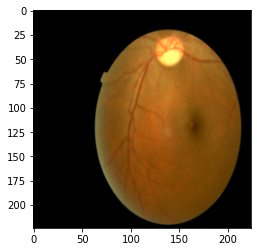

In [84]:
import matplotlib.pyplot as plt
plt.imshow(a[0][1].permute(1, 2, 0))

In [35]:
dataset.imgs

[('./data/test/0/05113073b268.png', 0),
 ('./data/test/0/0709652336e2.png', 0),
 ('./data/test/0/070d4ce5fd90.png', 0),
 ('./data/test/0/08c60c647673.png', 0),
 ('./data/test/0/0d9a9896f801.png', 0),
 ('./data/test/0/0da632ca45e0.png', 0),
 ('./data/test/0/0e0003ddd8df.png', 0),
 ('./data/test/0/0fe31196e0e8.png', 0),
 ('./data/test/0/10bf25731c08.png', 0),
 ('./data/test/0/10de500cf0c5.png', 0),
 ('./data/test/0/11d8e5eaee5b.png', 0),
 ('./data/test/0/12ef75375322.png', 0),
 ('./data/test/0/15b21c80cc31.png', 0),
 ('./data/test/0/15f8d769935c.png', 0),
 ('./data/test/0/1601c939412f.png', 0),
 ('./data/test/0/1633f8291a80.png', 0),
 ('./data/test/0/17d7d6b092f4.png', 0),
 ('./data/test/0/18cde9649e90.png', 0),
 ('./data/test/0/1fb455685328.png', 0),
 ('./data/test/0/218c822a3dd9.png', 0),
 ('./data/test/0/2585bbc91909.png', 0),
 ('./data/test/0/2923971566fe.png', 0),
 ('./data/test/0/2b10f138e67d.png', 0),
 ('./data/test/0/2f8d14a7d390.png', 0),
 ('./data/test/0/318eb706a134.png', 0),


In [36]:
dataset.samples

[('./data/test/0/05113073b268.png', 0),
 ('./data/test/0/0709652336e2.png', 0),
 ('./data/test/0/070d4ce5fd90.png', 0),
 ('./data/test/0/08c60c647673.png', 0),
 ('./data/test/0/0d9a9896f801.png', 0),
 ('./data/test/0/0da632ca45e0.png', 0),
 ('./data/test/0/0e0003ddd8df.png', 0),
 ('./data/test/0/0fe31196e0e8.png', 0),
 ('./data/test/0/10bf25731c08.png', 0),
 ('./data/test/0/10de500cf0c5.png', 0),
 ('./data/test/0/11d8e5eaee5b.png', 0),
 ('./data/test/0/12ef75375322.png', 0),
 ('./data/test/0/15b21c80cc31.png', 0),
 ('./data/test/0/15f8d769935c.png', 0),
 ('./data/test/0/1601c939412f.png', 0),
 ('./data/test/0/1633f8291a80.png', 0),
 ('./data/test/0/17d7d6b092f4.png', 0),
 ('./data/test/0/18cde9649e90.png', 0),
 ('./data/test/0/1fb455685328.png', 0),
 ('./data/test/0/218c822a3dd9.png', 0),
 ('./data/test/0/2585bbc91909.png', 0),
 ('./data/test/0/2923971566fe.png', 0),
 ('./data/test/0/2b10f138e67d.png', 0),
 ('./data/test/0/2f8d14a7d390.png', 0),
 ('./data/test/0/318eb706a134.png', 0),


In [39]:
len(dataset[0])

2

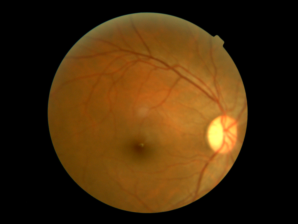

In [105]:
from PIL import Image
T = transforms.Resize(224)
T(Image.open('./data/test/0/0709652336e2.png'))

(-0.5, 223.5, 223.5, -0.5)

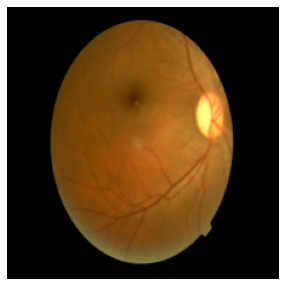

In [106]:
plt.figure(figsize=[5.5,5.0])
plt.imshow(dataset[1][0].permute(1, 2, 0))
plt.axis('off')

In [48]:
dataset[0][0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

In [43]:
dataset[0][0]

tensor([[[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
         [0.0235, 0.0235, 0.0196,  ..., 0.0235, 0.0235, 0.0235],
         [0.0235, 0.0235, 0.0196,  ..., 0.0235, 0.0196, 0.0235]],

        [[0.0314, 0.0275, 0.0275,  ..., 0.0275, 0.0314, 0.0275],
         [0.0275, 0.0275, 0.0314,  ..., 0.0275, 0.0275, 0.0275],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.

In [117]:
!pip install efficientnet_pytorch

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0e6c16ed9a9e0e752d308e63f8f287301980a5d434c7719fa14c868a7e648c7a
  Stored in directory: /home/abhijit/snap/jupyter/6/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [119]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/abhijit/snap/jupyter/6/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 60.3MB/s]


Loaded pretrained weights for efficientnet-b0


In [120]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [123]:
model = EfficientNet.from_name('efficientnet-b4')

In [124]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [127]:
import torch.nn as nn
model._fc = nn.Linear(in_features=1792, out_features=5)

In [128]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cpu')

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def valid_epoch(model, loader):

    model.eval()

    valid_loss = 0.0
    correct = 0.0

    all_predictions = []
    all_targets = []
    
    for batch_idx, (images, labels) in enumerate(loader):

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)

        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()

        all_predictions.extend(preds.cpu().tolist())
        all_targets.extend(labels.cpu().tolist())
        print("Batch",batch_idx+1,'/',len(loader))
    matrix = confusion_matrix(all_targets, all_predictions)

    return matrix

In [11]:
class_pr1iors = [0.4930010242403551, 0.101058381700239, 0.2727893479003073, 0.05257767156025948, 0.0805735745988392]

In [17]:
import numpy as np
import torch
torch.Tensor(class_priors).reshape(1,-1)

tensor([[0.4930, 0.1011, 0.2728, 0.0526, 0.0806]])

In [7]:
MEAN = (0.4152, 0.2218, 0.0740) 
STD = (0.2659, 0.1433, 0.0786) 
NEW_SIZE = (380, 380)
import os
os.chdir('/home/abhijit/nat/CAP5610/project')
transform=transforms.Compose([
                    transforms.Resize(NEW_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(MEAN, STD)])
data_dir = './data/test'
#os.chdir('../CAP5610/project/')
dataset = ImageFolder(data_dir,transform=transform,)

In [8]:
import config
from data_loader import get_loader1
test_loader = get_loader1(config, test=True)

Training on cpu


/home/abhijit/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [9]:
from utils import get_model
model = get_model(config)

EfficientB4 loaded
Model loaded to cpu


In [10]:
ckpt_path = './checkpoint/efficientnet-b4/Wednesday_21_April_2021_17h_58m_28s/efficientnet-b4-61-best.pth'
model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
conf_matrix = valid_epoch(model, test_loader)

In [ ]:
def quadratic_weighted_kappa(conf_mat):
    assert conf_mat.shape[0] == conf_mat.shape[1]
    cate_num = conf_mat.shape[0]

    # Quadratic weighted matrix
    weighted_matrix = np.zeros((cate_num, cate_num))
    for i in range(cate_num):
        for j in range(cate_num):
            weighted_matrix[i][j] = 1 - float(((i - j)**2) / ((cate_num - 1)**2))

    # Expected matrix
    ground_truth_count = np.sum(conf_mat, axis=1)
    pred_count = np.sum(conf_mat, axis=0)
    expected_matrix = np.outer(ground_truth_count, pred_count)

    # Normalization
    conf_mat = conf_mat / conf_mat.sum()
    expected_matrix = expected_matrix / expected_matrix.sum()

    observed = (conf_mat * weighted_matrix).sum()
    expected = (expected_matrix * weighted_matrix).sum()
    return (observed - expected) / (1 - expected)


In [23]:
import sys
sys.path.add('./runs')
from efficientnet-b4.Wednesday_21_April_2021_17h_58m_28s import config

SyntaxError: invalid syntax (<ipython-input-23-e9f29ffa774e>, line 3)

In [27]:
scriptpath = "./runs/efficientnet-b4.Wednesday_21_April_2021_17h_58m_28s"
import sys, os
# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(scriptpath))

# Do the import
import config

Training on cpu


In [28]:
exptA = 'resnet18/Tuesday_13_April_2021_23h_06m_53s/resnet18-17-best.pth'

In [34]:
'.runs/'+'/'.join(exptA.split('/')[:-1])

'.runs/resnet18/Tuesday_13_April_2021_23h_06m_53s'

In [43]:
report_root_path = './reports/'
weights_root_path = './checkpoint'
runs_root_path = './runs'
import re
def get_report(experiment_name, epoch=None):
    """
    Args:
        experiment_name (str): name of experiment as shown on tensorboard in the format model_name/date_time_of_experiement
        epoch (int): epoch number
    """
    weights_folder = os.path.join(weights_root_path, experiment_name)
    epoch = last_epoch(weights_folder)
    report_file_path = os.path.join(report_root_path, experiment_name, 'epoch_'+str(epoch)+'_report.txt')
    
    f = open(report_file_path, "r")
    print("Epoch", epoch)
    print(f.read())
    
def most_recent_weights(weights_folder):
    """
    return most recent created weights file
    if folder is empty return empty string
    """
    weight_files = os.listdir(weights_folder)
    if len(weights_folder) == 0:
        return ''

    regex_str = r'([A-Za-z0-9]+)-([0-9]+)-(regular|best)'

    # sort files by epoch
    weight_files = sorted(weight_files, key=lambda w: int(re.search(regex_str, w).groups()[1]))
    #print("weights files", weight_files)
    return weight_files[-1]

def last_epoch(weights_folder):
    weight_file = most_recent_weights(weights_folder)
    #print("weight file in last epoch", weight_file)
    if not weight_file:
        raise Exception('no recent weights were found')
    resume_epoch = int(weight_file.split('-')[2])

    return resume_epoch

def get_config_file(experiment_name):
    config_file_path = os.path.join(runs_root_path, experiment_name, 'config.py')
    f = open(config_file_path, "r")
    
    print(f.read())

In [44]:
expt_name = 'efficientnet-b4/Sunday_25_April_2021_00h_31m_05s'
get_report(expt_name)
get_config_file(expt_name)

Epoch 95
                  precision    recall  f1-score   support

           No DR       0.98      0.96      0.97       180
            Mild       0.62      0.78      0.69        37
        Moderate       0.83      0.78      0.80        99
          Severe       0.56      0.47      0.51        19
Proliferative DR       0.58      0.66      0.61        29

        accuracy                           0.84       364
       macro avg       0.71      0.73      0.72       364
    weighted avg       0.85      0.84      0.84       364


import torch
from torchvision import transforms

from datetime import datetime



WORK_DIR = '/home/abhijit/nat/CAP5610/project/'
DATA_DIR = WORK_DIR+'data/'
PLOTS_DIR = WORK_DIR+'plots/'
CHECKPOINT_PATH = WORK_DIR+'checkpoint/'
CSV_PATH = DATA_DIR+'train.csv'
TRAIN_IMG_PATH = DATA_DIR+'train/'
VAL_IMG_PATH = DATA_DIR+'val/'
TEST_IMG_PATH = DATA_DIR+'test/'
LOG_DIR = WORK_DIR+'runs'
REPORTS_DIR = WORK_DIR+'reports/'


NEW_SIZE = (380, 380)

# mean and std of RG

In [46]:
expt_name1 = 'efficientnet-b4/Wednesday_21_April_2021_17h_58m_28s'
get_report(expt_name1)
get_config_file(expt_name1)

Epoch 61
                  precision    recall  f1-score   support

           No DR       0.97      0.97      0.97       180
            Mild       0.59      0.81      0.68        37
        Moderate       0.78      0.74      0.76        99
          Severe       0.60      0.47      0.53        19
Proliferative DR       0.65      0.59      0.62        29

        accuracy                           0.83       364
       macro avg       0.72      0.71      0.71       364
    weighted avg       0.84      0.83      0.83       364


import torch
from torchvision import transforms

from datetime import datetime



WORK_DIR = '/home/abhijit/nat/CAP5610/project/'
DATA_DIR = WORK_DIR+'data/'
PLOTS_DIR = WORK_DIR+'plots/'
CHECKPOINT_PATH = WORK_DIR+'checkpoint/'
CSV_PATH = DATA_DIR+'train.csv'
TRAIN_IMG_PATH = DATA_DIR+'train/'
VAL_IMG_PATH = DATA_DIR+'val/'
TEST_IMG_PATH = DATA_DIR+'test/'
LOG_DIR = WORK_DIR+'runs'
REPORTS_DIR = WORK_DIR+'reports/'


NEW_SIZE = (380, 380)

# mean and std of RG

In [5]:
import torch
import torch.nn as nn


class LSR(nn.Module):

    def __init__(self, e=0.1, reduction='mean'):
        super().__init__()

        self.log_softmax = nn.LogSoftmax(dim=1)
        self.e = e
        self.reduction = reduction
    
    def _one_hot(self, labels, classes, value=1):
        """
            Convert labels to one hot vectors
        
        Args:
            labels: torch tensor in format [label1, label2, label3, ...]
            classes: int, number of classes
            value: label value in one hot vector, default to 1
        
        Returns:
            return one hot format labels in shape [batchsize, classes]
        """

        one_hot = torch.zeros(labels.size(0), classes)

        #labels and value_added  size must match
        labels = labels.view(labels.size(0), -1)
        value_added = torch.Tensor(labels.size(0), 1).fill_(value)

        value_added = value_added.to(labels.device)
        one_hot = one_hot.to(labels.device)

        one_hot.scatter_add_(1, labels, value_added)

        return one_hot

    def _smooth_label(self, target, length, smooth_factor):
        """convert targets to one-hot format, and smooth
        them.

        Args:
            target: target in form with [label1, label2, label_batchsize]
            length: length of one-hot format(number of classes)
            smooth_factor: smooth factor for label smooth
        
        Returns:
            smoothed labels in one hot format
        """
        one_hot = self._one_hot(target, length, value=1 - smooth_factor)
        one_hot += smooth_factor / length

        return one_hot.to(target.device)

    def forward(self, x, target):

        if x.size(0) != target.size(0):
            raise ValueError('Expected input batchsize ({}) to match target batch_size({})'
                    .format(x.size(0), target.size(0)))

        if x.dim() < 2:
            raise ValueError('Expected input tensor to have least 2 dimensions(got {})'
                    .format(x.size(0)))

        if x.dim() != 2:
            raise ValueError('Only 2 dimension tensor are implemented, (got {})'
                    .format(x.size()))


        smoothed_target = self._smooth_label(target, x.size(1), self.e)
        x = self.log_softmax(x)
        loss = torch.sum(- x * smoothed_target, dim=1)

        if self.reduction == 'none':
            return loss
        
        elif self.reduction == 'sum':
            return torch.sum(loss)
        
        elif self.reduction == 'mean':
            return torch.mean(loss)
        
        else:
            raise ValueError('unrecognized option, expect reduction to be one of none, mean, sum')


In [3]:
predictions = torch.rand(16,5)
predictions = predictions/predictions.sum(dim=1, keepdim=True)

In [4]:
import torch
targets = torch.randint(0,5,(16,))

In [14]:
def quadratic_weighted_kappa(conf_mat):
    assert conf_mat.shape[0] == conf_mat.shape[1]
    cate_num = conf_mat.shape[0]

    # Quadratic weighted matrix
    weighted_matrix = np.zeros((cate_num, cate_num))
    for i in range(cate_num):
        for j in range(cate_num):
            weighted_matrix[i][j] = 1 - float(((i - j)**2) / ((cate_num - 1)**2))

    # Expected matrix
    ground_truth_count = np.sum(conf_mat, axis=1)
    pred_count = np.sum(conf_mat, axis=0)
    expected_matrix = np.outer(ground_truth_count, pred_count)

    # Normalization
    conf_mat = conf_mat / conf_mat.sum()
    expected_matrix = expected_matrix / expected_matrix.sum()

    observed = (conf_mat * weighted_matrix).sum()
    expected = (expected_matrix * weighted_matrix).sum()
    return (observed - expected) / (1 - expected)


In [12]:
predictions.argmax(1).tolist()

[2, 3, 3, 0, 4, 0, 1, 0, 2, 4, 2, 3, 4, 2, 1, 4]

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(targets.tolist(), predictions.argmax(1).tolist())

In [16]:
print("quadratic weighted kappa (github script)", quadratic_weighted_kappa(cm))

quadratic weighted kappa (github script) -0.13705583756345177


In [2]:
def quadratic_kappa(actuals, preds, N=5):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    N = len(actuals)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

In [17]:
print("quadratic weighted kappa (kaggle script)", quadratic_kappa(targets.tolist(), predictions.argmax(1).tolist()))

quadratic weighted kappa (kaggle script) -0.13705583756345185


In [8]:
targets.eq(-100).eq(0)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [6]:
lsr_loss = LSR()

In [15]:
a=torch.Tensor([1, 1, 0, 4, 3, 4, 0, 0, 2, 4, 2, 1, 0, 3, 2, 0]).long()

In [18]:
labels = a.view(a.size(0),-1)

In [22]:
labels

tensor([[1],
        [1],
        [0],
        [4],
        [3],
        [4],
        [0],
        [0],
        [2],
        [4],
        [2],
        [1],
        [0],
        [3],
        [2],
        [0]])

In [20]:
value_added = torch.Tensor(labels.size(0),1).fill_(1)

In [25]:
one_hot = torch.zeros(labels.size(0), 5)
one_hot

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [34]:
lsr_loss._one_hot(targets, 5)

tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])

In [35]:
lsr_loss._smooth_label(targets, 5, 0.1).sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [37]:
predictions.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [2]:
targets[-100]

NameError: name 'targets' is not defined

In [39]:
lsr_loss(predictions, targets)

tensor(1.6145)

In [1]:
from pytorch_loss import LabelSmoothSoftmaxCEV1, LabelSmoothSoftmaxCEV2, LabelSmoothSoftmaxCEV3

ModuleNotFoundError: No module named 'pytorch_loss'